# Validació estructural del model

En aquest notebook es desenvolupa el que anomenem **Bloc 2** del treball, amb l’objectiu de validar estructuralment el model generatiu ajustat en el notebook anterior (`estimacio_p_i_q_sampling.ipynb`).
En el Bloc 1 es van estimar els paràmetres d’error `p_inf` i `q_inf` assumint una estructura base aleatòria (`L_wiring_nova`) i comparant-la amb la xarxa observada (`xarxa_obs`). A partir d’aquests paràmetres es va generar un conjunt de xarxes sintètiques (`A_model`) sota el model inferit.

L’objectiu d’aquest segon bloc és analitzar quina estructura emergent es deriva d’aquest model i com es comporta energèticament en relació amb la xarxa observada.

Concretament, els passos que es duran a terme són:

1. Generar un conjunt de xarxes sintètiques utilitzant `L_wiring_nova` i els paràmetres inferits `p_inf` i `q_inf`.
2. Aplicar la funció original `L_wiring` (majoria sobre un conjunt de xarxes alineades) a aquest conjunt generat, utilitzant permutació identitat.
3. Obtenir una nova blueprint estructural (`L_model`) derivada del model ajustat.
4. Calcular els valors d’`overlap` i de l’`hamiltonian_prob` tant per al conjunt de xarxes generades com per a la xarxa observada.
5. Comparar la distribució d’energies simulades amb l’energia de la xarxa real.

Aquest procediment permet realitzar una validació estructural del model: si la xarxa observada presenta una energia coherent amb la distribució generada pel model inferit, es pot considerar que el model és compatible amb les propietats estructurals de les dades.

In [1]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import permutations

### Carreguem dades

In [2]:
xarxa_obs = np.load("A2_blueprint.npy")
Nx=xarxa_obs.shape[0]
Ny=xarxa_obs.shape[1]

## Generació del wiring aleatori

In [3]:
def L_wiring_random(Nx, Ny): 
    L_wiring= np.zeros((Nx,Ny))

    for i in range(0,Nx):
        for j in range(0, Ny):
            if np.random.rand() < 0.5:
                L_wiring[i,j]=1
            else:
                L_wiring[i,j]=0
    #vull imposar que la diagonal sigui 0
    for i in range(0, min(Nx,Ny)):
        L_wiring[i,i]=0
    return L_wiring

np.random.seed(0)  # opcional pero recomendable

L_wiring_nova = L_wiring_random(Nx, Ny)
print(f"L_wiring generada aleatòriament té la forma:{L_wiring_nova.shape}")
#vull imprimir la diagonal per comprovar que és 0
print("Diagonal de L_wiring_nova:") 
print(np.diag(L_wiring_nova))
print("Primeres 5 posicions son: ")
print(L_wiring_nova[:5,:5])

L_wiring generada aleatòriament té la forma:(224, 224)
Diagonal de L_wiring_nova:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Primeres 5 posicions son: 
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0.]]


## Estimació dels paràmetres p* i q*

In [4]:
#inicialitzo els comptadors
zeros_wiring = 0 #nombre de zeros en la matriu de L_wiring_nova
uns_wiring = 0 #nombre d'uns en la matriu de L_wiring_nova

nre_q = 0 #casos L_wiring_nova[i][j] = 1 i xarxa_obs[i][j] = 0
nre_p = 0 #casos L_wiring_nova[i][j] = 0 i xarxa_obs[i][j] = 1

for i in range(0,Nx):
    for j in range(0,Ny):
        if L_wiring_nova[i][j]==0:
            zeros_wiring += 1
            if xarxa_obs[i][j]==1:
                nre_p+=1
        else: #L_wiring_nova[i][j]==1
            uns_wiring += 1
            if xarxa_obs[i][j]==0:
                nre_q+=1
#calculo p_inf i q_inf (inferits)
q_inf = nre_q/uns_wiring #probabilitat d'un fals negatiu
p_inf = nre_p/zeros_wiring #probabilitat d'un fals positiu

print("q_inf (probabilitat d'eliminar un enllaç existent): ", q_inf)
print("p_inf (probabilitat d'afegir un enllaç inexistent): ", p_inf)

q_inf (probabilitat d'eliminar un enllaç existent):  0.956578999880273
p_inf (probabilitat d'afegir un enllaç inexistent):  0.04371193120745252


##  Generació de l’ensemble de xarxes

In [5]:
def generar_xarxa_sintetica(L_wiring_nova, p_inf, q_inf):
    Nx = L_wiring_nova.shape[0]
    Ny = L_wiring_nova.shape[1]
    L_sint = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            if L_wiring_nova[i][j]==1: 
            #enllaç existent que pot ser eliminat amb probabilitat q_inf
                if np.random.rand() >= q_inf:
                    L_sint[i][j]=1
            else:
                #enllaç inexistent que pot ser afegit amb probabilitat p_inf
                if np.random.rand() < p_inf:
                    L_sint[i][j]=1
    return L_sint 

In [6]:
L_sint=generar_xarxa_sintetica(L_wiring_nova, p_inf, q_inf)
print(f"L_sint generada té la forma:{L_sint.shape}")
print("Nombre d'enllaços en L_sint: ", np.sum(L_sint))

L_sint generada té la forma:(224, 224)
Nombre d'enllaços en L_sint:  2236.0


In [7]:
nre_xarxes = 300 
Nx = L_wiring_nova.shape[0]
Ny = L_wiring_nova.shape[1]
A_model=np.zeros((nre_xarxes,Nx,Ny))

for k in range(0,nre_xarxes):
    A_model[k,:,:]=generar_xarxa_sintetica(L_wiring_nova, p_inf, q_inf)
    
print(f"A_model generada te la forma", A_model.shape)
#for i in range(nre_xarxes):
    #print(f"Nombre d'enllaços a la xarxa {i}: {np.sum(A_model[i,:,:])}")

A_model generada te la forma (300, 224, 224)


## Càlcul de l’energia

### Funcions d'energia

In [8]:
#paràmetres del hamiltonià que es fan servir al paper
alpha = 1.0
beta = 5.0

In [9]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):

    A_1 = overlap_1 + alpha #o11 al paper
    B_1 = (Edges_L - overlap_1 + beta) #o10 al paper
    C_1 = Edges_L + alpha + beta #o1 al paper
    
    A_0 = overlap_0 + alpha #o00 al paper
    B_0 = (Edges_NoL - overlap_0 + beta) # o01 al paper
    C_0 = Edges_NoL + alpha + beta # o0 al paper
    
    #  [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1) 
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0) 
    
    H = -(H1 + H0)
    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): 
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f]) #es tradueix l'index del bliueprint al real de 
                 #(per exemple, si el node 1 de L es el node 5 de A, p_f=5)
                p_c=int(P_inv_f[k,c])  
                valor_L, valor_A = L_f[f,c], A_f[k,p_f,p_c] #compara el valor de L i A a la posició corresponent
                
                ovlp_0[k] = ovlp_0[k] + (1-valor_L)*(1-valor_A )#mira si els zeros coincideixen a L i a A
                ovlp_1[k] = ovlp_1[k] + valor_L*valor_A #mira si els 1s coincideixen a 0 i a  A
                
                
    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0)) #se sumen coincidencies en totes les observacions, resultat global
    return ovlp_0, ovlp_1
#retorna ovlp_0 (nre total de no-enllaços ben predits) i ovlp_1 (nre total d'enllacos ben predits)

@jit(nopython=True) # The blueprint is the average of the observations (taking into account the mapping)  
def L_wiring(A_f, P_inv_f): #enlaces que aparecen en la mayoría de observaciones
    #A_f:  te la forma KxNxNy, on K és el nre de xarxes observades
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0] 
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
                #per cada posicio (ij) mira en les K xarxes la posicio que li correspon al blueprint (equivalent segons el mapping)
                p1 = int(P_inv_f[k,i]) # Mapping of the observations
                p2 = int(P_inv_f[k,j]) # Mapping of the observations
                L_new_f[i,j] += A_f[k,p1,p2] #sumo les connexions existents a la posició equivalent en les K xarxes observades
            valor_lnew=1/K* L_new_f[i,j] #fa la mitjana de connexions existents en les K xarxes observades
            L_new_f[i,j] = round( valor_lnew ) #redondeja al valor més proper
            # If valor_lnew = 0, L=0 (we could establish L=1, but it is more probable to not have a connection)
            #L_ij=1--> a la majoria de les k observacions alineades hi ha enllaç aquí
            # L_ij=0--> a la majoria de les k observacions alineades no hi ha enllaç aquí 
    return L_new_f



In [10]:
#definim la permutació identitat per a cada una de les xarxes generades
#volem avaluar el hamiltonià amb la permutació identitat per a cada una de les mostres generades
P_inv_id = np.tile(np.arange(Nx), (nre_xarxes, 1))
#tile empila nre_xarxes vegades la matriu [0,1,2,...,Nx-1] perque cada xarxa tingui la seva pròpia matriu identitat

In [ ]:
# Construir Ao a enters i identitat (P_inv_id)
Ao_enters = A_model.astype(int)       # aqui convertim a int per si de cas havia quedat amb floats després de fer rand
P_inv_id = np.tile(np.arange(Nx), (nre_xarxes, 1)) 
#tile empila num_networks vegades la matriu [0,1,2,...,Nx-1] perque cada xarxa tingui la seva pròpia matriu identitat
#Cridar L_wiring 
print("Aplico L_wiring")
L_model = L_wiring(Ao_enters, P_inv_id)
print("L_model num 1s :", np.sum(L_model))


#ara calculem els overlaps i l'energia per la xarxa observada, amb la permutació identitat, és a dir, sense permutar els nodes, només volem avaluar el hamiltonià per la xarxa observada amb la permutació identitat
A_obs = xarxa_obs.reshape(1, Nx, Ny) #li dono la forma (1, Nx, Ny) per que la funció overlap_total_prob espera una matriu de K observacions, en aquest cas només tenim 1 observació, la xarxa observada, per això el 1 a la primera dimensió
P_inv_obs = np.arange(Nx).reshape(1, Nx)

ovlp0_obs, ovlp1_obs = overlap_total_prob(L_model, A_obs, P_inv_obs)

Edges_L_obs = int(np.sum(L_model)) #nombre d'enllaços en L_model
Edges_NoL_obs = Nx * Ny - Edges_L_obs #nombre de no-enllaços en L_model, que es el total de posicions (Nx*Ny) menys els enllaços existents

H_obs = hamiltonian_prob(Edges_NoL_obs, Edges_L_obs, ovlp0_obs, ovlp1_obs, alpha, beta)

print("Energia observada:", H_obs)

#ara energia per les xarxes generades, amb la permutació identitat, és a dir, sense permutar els nodes, només volem avaluar el hamiltonià per cada mostra generada amb la permutació identitat
H_dist = []

for k in range(nre_xarxes):

    A = Ao_enters[k].reshape(1, Nx, Ny)

    ovlp0, ovlp1 = overlap_total_prob(L_model,A,P_inv_obs)

    H = hamiltonian_prob(Edges_NoL_obs,Edges_L_obs,ovlp0,ovlp1,alpha,beta)

    H_dist.append(H)
print("Energia mitjana de les xarxes generades:", np.mean(H_dist))

#calculem energia de L_model respecte a si mateixa, és a dir, avaluem el hamiltonià amb L_model com a xarxa observada i amb la permutació identitat, per veure quina energia té el blueprint respecte a si mateix
A_L = L_model.reshape(1, Nx, Ny)
P_inv_L = np.arange(Nx).reshape(1, Nx)

ovlp0_L, ovlp1_L = overlap_total_prob(L_model, A_L, P_inv_L)

H_L = hamiltonian_prob(Edges_NoL_obs, Edges_L_obs, ovlp0_L, ovlp1_L, alpha,beta)

print("Energia de L_model respecte a si mateixa:", H_L)
print("Nombre mitjà d'enllaços a A_model:",
      np.mean([np.sum(A_model[k]) for k in range(nre_xarxes)]))


Aplico L_wiring
L_model num 1s : 0.0
Energia observada: 9007.646424620667
Energia mitjana de les xarxes generades: 9001.449395735546
Energia de L_model respecte a si mateixa: 52.54814353744662
Nombre mitjà d'enllaços a A_model: 2184.1566666666668


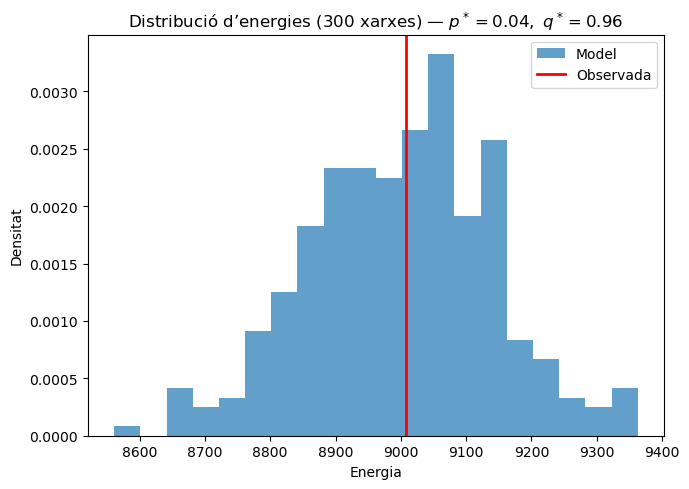

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

plt.hist(H_dist, bins=20, density=True, alpha=0.7, label="Model")
plt.axvline(H_obs, color='r', lw=2, label="Observada")

plt.title(
    rf"Distribució d’energies ({len(H_dist)} xarxes) — "
    rf"$p^*={p_inf:.2f},\ q^*={q_inf:.2f}$"
)

plt.xlabel("Energia")
plt.ylabel("Densitat")
plt.legend()
plt.tight_layout()

# plt.savefig(f"histograma_energies_{len(H_dist)}_xarxes.png", dpi=300)

plt.show()


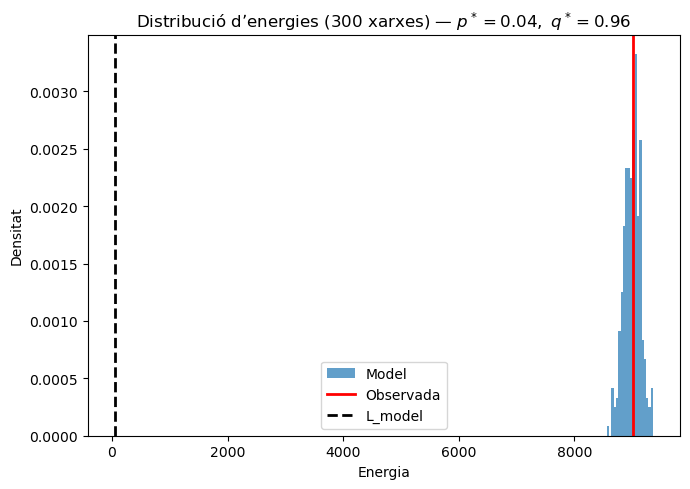

In [19]:
plt.figure(figsize=(7,5))

plt.hist(H_dist, bins=20, density=True, alpha=0.7, label="Model")

plt.axvline(H_obs, color='r', lw=2, label="Observada")
plt.axvline(H_L, color='k', lw=2, linestyle='--', label="L_model")

plt.title(
    rf"Distribució d’energies ({len(H_dist)} xarxes) — "
    rf"$p^*={p_inf:.2f},\ q^*={q_inf:.2f}$"
)

plt.xlabel("Energia")
plt.ylabel("Densitat")
plt.legend()
plt.tight_layout()
plt.show()
